# Procedure for Evaluating the Simple Papell Model

**Objective**: Adjust the hyperparameters of the proposed simple Papell model in order to maximize the model's accuracy.

- Evaluation Metric: AIC
- Evaluation Procedure: Cross-validation on a moving time window of size $h$.

For a set of parameters $(h, \lambda)$:

- Information from $t - h$ to $t$. Calculated with a simple *Nowcasting* procedure.
    - Nowcasting $\mathbb{E}_{t-1}[\pi_{t}]$.
    - Nowcasting $\mathbb{E}_{t-1}[\tilde{\pi}_{t}]$.
    - Nowcasting $\mathbb{E}_{t-1}[y_{t}]$.
    - Nowcasting $\mathbb{E}_{t-2}[\tilde{y}_{t}]$.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import toolz as tz
import numpy as np
import src

import itertools as itt

import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

In [2]:
data = pd.read_csv('data/processed_data.csv', index_col=0, parse_dates=True)

In [3]:
# Defining the variables to be used in the nowcasting procedure and the lags
# to update.
variables = {
    'pi': {
        'lag': 1,
        'nowcast': src.pi_nowcast_
    },
    'pi_star': {
        'lag': 1,
        'nowcast': src.pi_nowcast_
    },
    'Y': {
        'lag': 1,
        'nowcast': src.gap_nowcast_
    },
    'Y_star': {
        'lag': 2,
        'nowcast': src.gap_nowcast_
    }
}

In [4]:
# Defining the rolling AIC function to be used in the grid search procedure.
# Bootstrap is set to True.
def rolling_aic(X: pd.DataFrame, y: pd.Series, h: int, alpha: float) -> float:
    data_nowcasted = src.nowcasting_(X, y, lags=variables)
    data_papell = tz.pipe(
        data_nowcasted,
        lambda x: x.assign(diff_inf = x.iloc[:, 2] - x.iloc[:, 1]),
        lambda x: x.assign(diff_y = x.iloc[:, 4] - x.iloc[:, 3]),
        lambda x: x.iloc[:, [0, 5, 6]]
    )
    return src.rolling_aic_model_(
        data = data_nowcasted,
        alpha = alpha,
        h = h,
        agg=np.mean, 
        bootstrap=True
    )

In [5]:
#Defining the rolling MSFE function to be used in the grid search procedure.
#Bootstrap is set to True.
def rolling_msfe(X: pd.DataFrame, y: pd.Series, h: int, alpha: float) -> float:
    data_nowcasted = src.nowcasting_(X, y, lags=variables)
    data_papell = tz.pipe(
        data_nowcasted,
        lambda x: x.assign(diff_inf = x.iloc[:, 2] - x.iloc[:, 1]),
        lambda x: x.assign(diff_y = x.iloc[:, 4] - x.iloc[:, 3]),
        lambda x: x.iloc[:, [0, 5, 6]]
    )
    return src.rolling_msfe_model_(
        data = data_nowcasted,
        alpha = alpha,
        h = h,
        bootstrap=True,
        agg=lambda x: np.mean(x**2)
    )

In [6]:
# Grid search for the hyperparameters h and alpha.
grid_ = {
    'h':list(range(6, 24)),
    'alpha': np.linspace(0, 1, 40)
}
grid_ = list(itt.product(grid_['h'], grid_['alpha']))

In [7]:
# Parallelizing the grid search.
def map_rolling_aic(args):
    x, h, alpha = args
    return rolling_aic(data.drop(columns='S'), data['S'], h, alpha)

In [8]:
def map_rolling_msfe(args):
    x, h, alpha = args
    return rolling_msfe(data.drop(columns='S'), data['S'], h, alpha)

In [9]:
with multiprocessing.Pool() as p:
    msfe_values = p.map(
        map_rolling_msfe, 
        [(data, x[0], x[1]) for x in grid_]
    )

In [10]:
with multiprocessing.Pool() as p:
    aic_values = p.map(
        map_rolling_aic, 
        [(data, x[0], x[1]) for x in grid_]
    )

In [11]:
# Dataframe with MSFE values and hyperparameters.
msfe_values = pd.DataFrame(
    {
        'h': [x[0] for x in grid_],
        'alpha': [x[1] for x in grid_],
        'msfe': msfe_values
    }
)

In [12]:
# Dataframe with AIC values and hyperparameters.
aic_values = pd.DataFrame(
    {
        'h': [x[0] for x in grid_],
        'alpha': [x[1] for x in grid_],
        'aic': aic_values
    }
)

In [13]:
aic_values.to_csv('data/aic_values.csv', index=False)

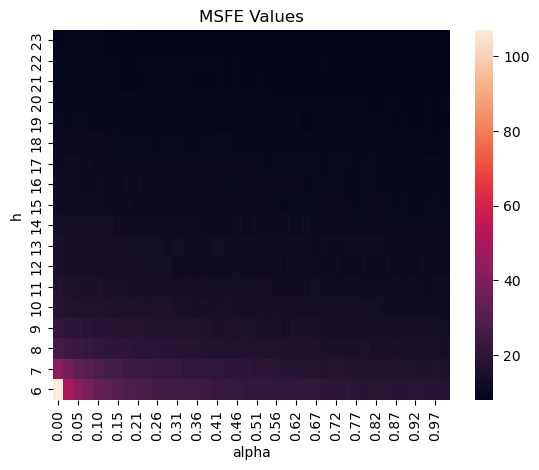

In [14]:
# Heatmap for the MSFE values.
msfe_values_heatmap = msfe_values.pivot(index='h', columns='alpha', values='msfe')
msfe_values_heatmap = msfe_values_heatmap.sort_index(ascending=False)

fig, ax = plt.subplots()
sns.heatmap(msfe_values_heatmap, ax=ax)
x_tick_labels = [item.get_text() for item in ax.get_xticklabels()]
formatted_labels = [f"{float(label):.2f}" for label in x_tick_labels]
ax.set_xticklabels(formatted_labels, rotation=90)  # Aplicar las etiquetas formateadas al eje X

ax.set_title('MSFE Values')

plt.show()

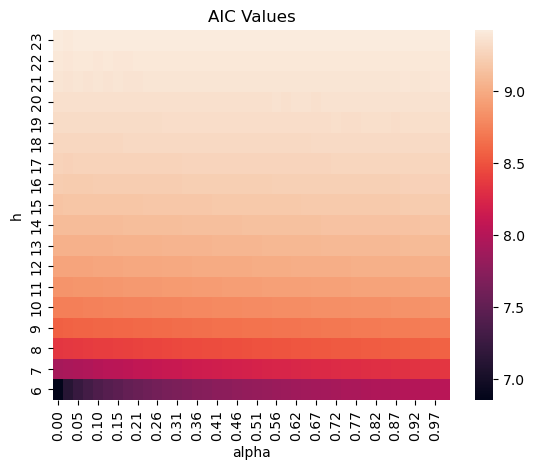

In [15]:
# Heatmap for the AIC values.
aic_values_heatmap = aic_values.pivot(index='h', columns='alpha', values='aic')
aic_values_heatmap = aic_values_heatmap.sort_index(ascending=False)

fig, ax = plt.subplots()
sns.heatmap(aic_values_heatmap, ax=ax)
x_tick_labels = [item.get_text() for item in ax.get_xticklabels()]
formatted_labels = [f"{float(label):.2f}" for label in x_tick_labels]
ax.set_xticklabels(formatted_labels, rotation=90)  # Aplicar las etiquetas formateadas al eje X

ax.set_title('AIC Values')

plt.show()